# Geospatial Analysis of Crash Cases in Philadelphia from 2010 - 2021

This data is aggregated by Police District.

In [295]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas

In [296]:
# Spatial Plot
philly_map = geopandas.read_file("./Boundaries_District/Boundaries_District.shp")
philly_map_2 = philly_map.copy()
# Crash Dataset
df = pd.read_csv("./APAC_2023_Datasets/Crashes/crash_info_general.csv")

/var/folders/5n/7955wqx52_s2p0fymgbx_vsh0000gn/T/ipykernel_83141/4293016727.py:5: DtypeWarning: Columns (97,98,99) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/Users/pongyizhen/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Y2S2_Citadel comps/APAC_2023_Datasets/Crashes/crash_info_general.csv")


In [297]:
#add binary column for whether pedestraints were involved
df['ped_involved'] = df['PED_COUNT'].apply(lambda x: 1 if x > 0 else 0)

#add binary column for whether there were deaths or serious injuries for pedestrains
df['ped_dead_or_injured_seriously'] = (df['PED_DEATH_COUNT'] + df['PED_SUSP_SERIOUS_INJ_COUNT']).apply(lambda x: 1 if x > 0 else 0)

In [298]:
# Create GeoSpatial DataFrame
crashes_coords = geopandas.GeoDataFrame(
    df,
    geometry=geopandas.points_from_xy(df['DEC_LONG'], df['DEC_LAT'])
)

In [299]:
# Map to district
crashes_coords['DISTRICT_'] = ''
for idx in range(philly_map.shape[0]):
    pip = crashes_coords.within(philly_map.loc[idx, 'geometry'])
    if pip.sum() > 0:
        crashes_coords.loc[pip, 'DISTRICT_'] = philly_map.loc[idx, 'DISTRICT_']
  

In [300]:
#Filter out invalid cases that do not fall within the districts
crashes_coords = crashes_coords[crashes_coords['DISTRICT_'] != '']


In [301]:
#group by district and count, before filter
stats_before_filter = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

print(stats_before_filter)

             CRN
DISTRICT_       
1           3333
2           6270
3           6475
5           1999
6           6995
7           4272
8           7706
9           4967
12          8005
14          5866
15         12130
16          8840
17          2537
18          7567
19          4887
22          6135
24          6893
25          7485
26          5183
35          7089
39          6890
77            44


In [302]:
#group by district and count, filter for pedestrains involved
crashes_coords = crashes_coords[crashes_coords['ped_involved'] == 1]
stats_w_pedestrains = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

print(stats_w_pedestrains)

            CRN
DISTRICT_      
1           319
2           964
3           976
5           261
6          1140
7           418
8           473
9           866
12          868
14          939
15         1463
16          490
17          427
18         1281
19          905
22         1184
24         1079
25         1285
26          735
35         1394
39          914
77            7


In [303]:
# Filter cases with deaths and serious injuries for pedestrains
crashes_coords = crashes_coords[crashes_coords['ped_dead_or_injured_seriously'] == 1]

In [304]:
#Group by district and count
stats = crashes_coords.groupby(['DISTRICT_'])[['CRN']].count()

stats = stats.sort_values(by="CRN", ascending=False)
print(stats)

           CRN
DISTRICT_     
15         142
25         131
35         112
24         100
22          92
12          86
2           83
39          79
6           78
18          76
26          72
19          62
3           60
8           56
9           49
14          43
16          39
17          27
7           24
1           23
5           17


In [305]:
stats_ratio = stats.merge(stats_w_pedestrains, on = 'DISTRICT_')
stats_ratio = stats_ratio.reset_index()
stats_ratio['ratio'] = stats_ratio['CRN_x']/ stats_ratio['CRN_y']


stats_ratio = stats_ratio.sort_values(by="ratio", ascending=False)
print(stats_ratio)

    DISTRICT_  CRN_x  CRN_y     ratio
13          8     56    473  0.118393
1          25    131   1285  0.101946
5          12     86    868  0.099078
10         26     72    735  0.097959
0          15    142   1463  0.097061
3          24    100   1079  0.092678
7          39     79    914  0.086433
6           2     83    964  0.086100
2          35    112   1394  0.080344
16         16     39    490  0.079592
4          22     92   1184  0.077703
19          1     23    319  0.072100
11         19     62    905  0.068508
8           6     78   1140  0.068421
20          5     17    261  0.065134
17         17     27    427  0.063232
12          3     60    976  0.061475
9          18     76   1281  0.059329
18          7     24    418  0.057416
14          9     49    866  0.056582
15         14     43    939  0.045793


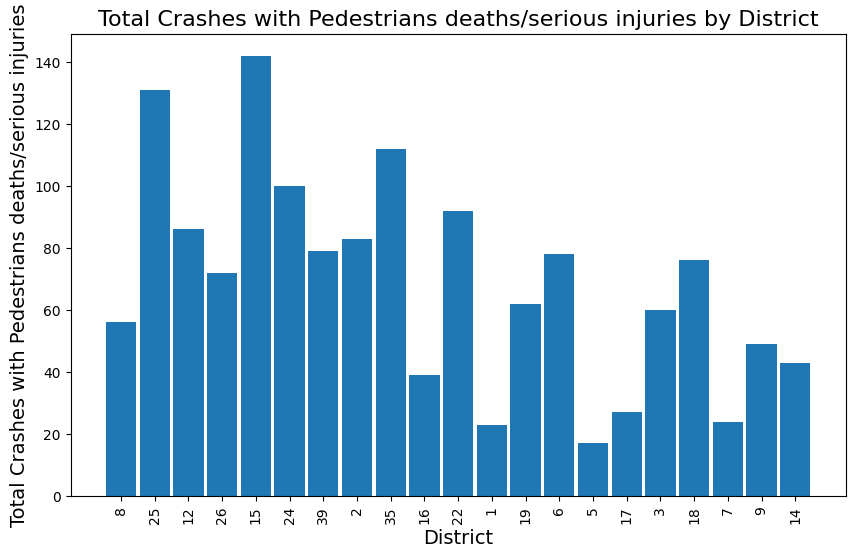

In [306]:
# create a figure and axis object
fig, ax = plt.subplots(figsize=(10,6))
stats_ratio_copy = stats_ratio.copy()
stats_ratio_copy['DISTRICT_'] = stats_ratio_copy['DISTRICT_'].astype(str)
#stats_ratio = stats_ratio.sort_values(by="CRN_x", ascending=False)

# create a bar plot with district on x-axis and CRN_x on y-axis
bar_plot = ax.bar(stats_ratio_copy['DISTRICT_'], stats_ratio_copy['CRN_x'], width=0.9)

# set plot title and axis labels
ax.set_title('Total Crashes with Pedestrians deaths/serious injuries by District', fontsize=16)
ax.set_xlabel('District', fontsize=14)
ax.set_ylabel('Total Crashes with Pedestrians deaths/serious injuries', fontsize=14)

# rotate x-axis labels for better readability
plt.xticks(rotation=90)

# display the plot
plt.show()

In [307]:
# Merge count into map
map_and_stats = philly_map.merge(stats, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

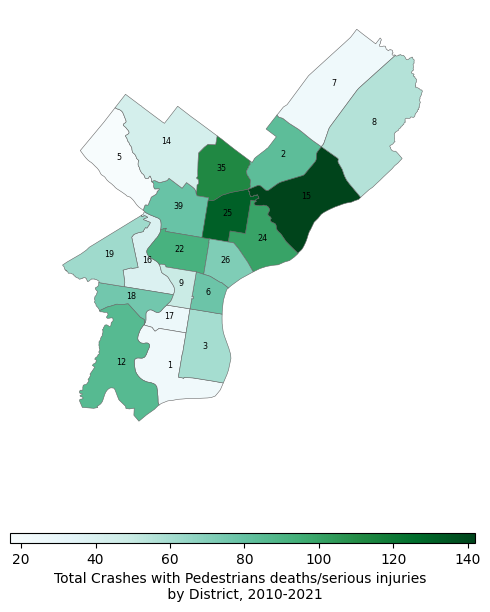

In [308]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats.plot(
    column='CRN',
    cmap='BuGn',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Total Crashes with Pedestrians deaths/serious injuries \n by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')

In [309]:
# Merge count into map if we using stats ratio
map_and_stats2 = philly_map_2.merge(stats_ratio, on='DISTRICT_')

(-75.2965363338824, -74.939522217298, 39.853475402027584, 40.15148900478962)

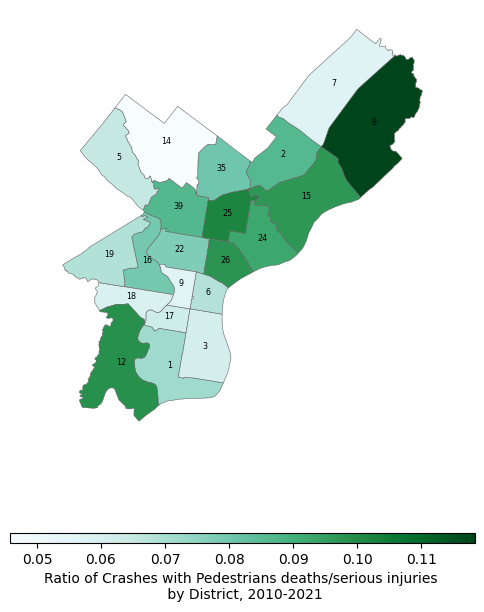

In [310]:
fig, ax = plt.subplots(1, figsize=(12,8))
plt.xticks(rotation=90)
map_and_stats2.plot(
    column='ratio',
    #column='CRN',
    cmap='BuGn',
    linewidth=0.4,
    ax=ax,
    edgecolor='.4',
    legend=True,
    legend_kwds={
        'label': "Ratio of Crashes with Pedestrians deaths/serious injuries \n by District, 2010-2021",
        'orientation': 'horizontal',
        'shrink': 0.5,
        'aspect': 50
    }
)
map_and_stats2.apply(lambda x: ax.annotate(text=x['DIST_NUM'], xy=x.geometry.centroid.coords[0], ha='center', fontsize='xx-small'), axis=1)
ax.axis('off')